In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
!wget https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/mnist_test.csv
!wget https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset

--2025-10-25 21:19:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.data.1’

iris.data.1             [ <=>                ]   4.44K  --.-KB/s    in 0s      

2025-10-25 21:19:54 (76.2 MB/s) - ‘iris.data.1’ saved [4551]

--2025-10-25 21:19:54--  https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/mnist_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [text/plain]
Saving to: ‘mnist_test.csv.1’

mnist_test.csv.1    100%[===================>]  17.44M

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [26]:
import matplotlib.pyplot as plt
!pip install ipympl
%matplotlib inline

In [27]:
iris_df = pd.read_csv (
"https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",header = None)
mnist_df = pd.read_csv (
"https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/mnist_test.csv",header = None)

In [28]:

def prepare_dataset(dataset):
  n = len(dataset)
  index = np.random.permutation(n)

  perc = int(n * 0.2)

  test_idx = index[:perc]
  train_idx = index[perc:]

  X_test = dataset.iloc[test_idx, 0:4]
  Y_test = dataset.iloc[test_idx, 4]

  X_train = dataset.iloc[train_idx, 0:4]
  Y_train = dataset.iloc[train_idx, 4]
  return X_test,Y_test,X_train,Y_train

  #WRONG! dataset are different!

In [2]:
class KNearestNeighbors:
    def __init__(self, k, distance_metric="euclidean",weights = "uniform"):
        self.k = k
        self.distance_metric = distance_metric
        self . weights = weights

    def change_parameters(self,k,distance_metric,weights):
        self.k = k
        self.distance_metric = distance_metric
        self . weights = weights

    def _euclidean_distance(self, X_test):
        X_diff = self.X_train_reshaped - X_test.to_numpy()   #120,30,4
        dist_matrix = np.sum(X_diff**2,axis=2)**0.5     #120,30
        return dist_matrix.T

    def _cosine_distance(self, X_test):
        X_test_norm = ((X_test**2).sum(axis=1)**0.5).values.reshape(1, -1)
        dot = self.X_train @ X_test.T
        dist_matrix = 1 - np.abs(dot / (self.X_train_norm * X_test_norm))
        return dist_matrix.T

    def _manhattan_distance(self,X_test):
        X_diff = self.X_train_reshaped - X_test.to_numpy()
        dist_matrix = np.sum(np.abs(X_diff),axis=2)
        return dist_matrix.T

    def fit(self, X, y):
        """
        Store the 'prior knowledge' of your model that will be used to predict new labels.
        :param X: input data points, ndarray, shape = (R, C).
        :param y: input labels, ndarray, shape = (R,).
        """
        self.X_train = X
        self.Y_train = y

        self.X_train_reshaped = np.expand_dims(X_train,1)  #120,1,4
        self.X_train_norm = ((X_train**2).sum(axis=1)**0.5).values.reshape(-1, 1)

    def _majority_voting(self, k_best):

        labels = k_best.map(lambda x: Y_train.iloc[x])   #like java lambda function
        predictions = labels.mode(axis=1)[0]
        return predictions


    def weighted_vote_row(self,labels_row, weights_row):    #for each row gives the prediction
      label_weights = {}
      for lbl, w in zip(labels_row, weights_row):
          label_weights[lbl] = label_weights.get(lbl, 0) + w      #.get(): if exist return value of lbl, otherwise 0
      return max(label_weights, key=label_weights.get)          #reurn the label with max value

    def _weighted_voting (self,k_best,dist_matrix):
        distances_sorted = np.sort(dist_matrix, axis=1)[:, :self.k]
        weight_matrix = 1 / (distances_sorted + 1e-8)
        labels = k_best.map(lambda x: Y_train.iloc[x])
        predictions = []
        for index, row in labels.iterrows():
            predictions.append(self.weighted_vote_row(row, weight_matrix[index]))
        return pd.Series(predictions)

    def predict(self, X):
        """
        Run the KNN classification on X.
        :param X: input data points, ndarray, shape = (N, C).
        :return: labels, ndarray, shape = (N,).
        """

        if self.distance_metric== "euclidean":
          dist_matrix = self._euclidean_distance(X)

        elif self.distance_metric== "cosine":
          dist_matrix = self._cosine_distance(X)
        elif self.distance_metric == "manhattan":
          dist_matrix = self._manhattan_distance(X)



        k_best = np.argsort(dist_matrix)[:,:self.k]   #matrix 30 x k where k are the closest indexes
        if self.weights == "uniform":


          predictions = self._majority_voting(pd.DataFrame(k_best))

        elif self.weights == "distance":
          predictions = self._weighted_voting(pd.DataFrame(k_best),dist_matrix)


        return predictions

In [3]:
def calculate_accuracy(Y_test,Y_predicted):
  eq = Y_test.values.reshape(-1) == Y_predicted.values.reshape(-1)
  return np.count_nonzero(eq)/len(Y_test)*100

In [31]:
"""KKN = KNearestNeighbors(50,"euclidean","distance")
KKN.fit(X_train, Y_train)
Y_predicted =KKN.predict(X_test)

print(f"The accuracy is: {accuracy(Y_test,Y_predicted)}%")"""



'KKN = KNearestNeighbors(50,"euclidean","distance")\nKKN.fit(X_train, Y_train)\nY_predicted =KKN.predict(X_test)\n\nprint(f"The accuracy is: {accuracy(Y_test,Y_predicted)}%")'

In [32]:
"""k_best = pd.DataFrame(k_best)
df_new = k_best.map(lambda x: Y_train.iloc[x])     #like java lambda function
print(df_new.mode(axis=1))"""



'k_best = pd.DataFrame(k_best)\ndf_new = k_best.map(lambda x: Y_train.iloc[x])     #like java lambda function\nprint(df_new.mode(axis=1))'

# Try on iris/mnist:


In [33]:
X_test,Y_test,X_train,Y_train = prepare_dataset(iris_df)

KKN = KNearestNeighbors(30,"manhattan","uniform")
KKN.fit(X_train, Y_train)
Y_predicted =KKN.predict(X_test)

print(f"The accuracy is: {calculate_accuracy(Y_test,Y_predicted)}%")




The accuracy is: 93.33333333333333%


Playing with hyperparameters

In [4]:



def plot_different_k(k_start, k_end, distance="cosine", weights="distance"):
    KKN = KNearestNeighbors(0, distance, weights)
    KKN.fit(X_train, Y_train)

    accuracies = []
    k_values = list(range(k_start, k_end + 1))

    for k in k_values:
        KKN.change_parameters(k, distance, weights)
        Y_predicted = KKN.predict(X_test)
        acc = calculate_accuracy(Y_test, Y_predicted)
        accuracies.append(acc)

    # Plot accuracy trend
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
    plt.title(f"Accuracy vs. K ({distance} distance, weights={weights})")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

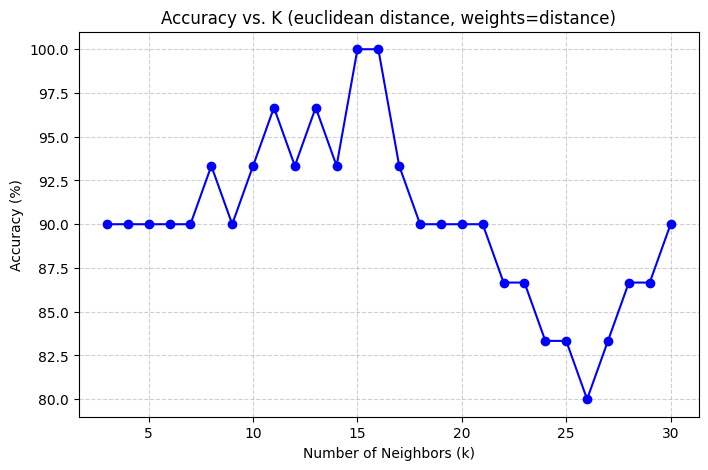

In [35]:
plot_different_k(3,30, distance="euclidean", weights="distance")

Excursus su titanic


In [3]:
titanic_test = pd.read_csv("test.csv")
titanic_train = pd.read_csv("train.csv")

In [15]:


titanic_train = pd.DataFrame(titanic_train)
titanic_test = pd.DataFrame(titanic_test)




X_test = titanic_test.loc[:, ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]]
ids = titanic_test.loc[:, ["PassengerId"]]


X_train = titanic_train.loc[:, ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]]
Y_train = titanic_train.iloc[:, 1]

X_test["Age"].fillna(X_test["Age"].median(), inplace=True)
X_test["Embarked"].fillna(X_test["Embarked"].mode()[0], inplace=True)
X_train["Age"].fillna(X_train["Age"].median(), inplace=True)
X_train["Embarked"].fillna(X_train["Embarked"].mode()[0], inplace=True)



X_test = pd.get_dummies(X_test, columns=["Sex", "Embarked"], drop_first=True) #Convert string columns in values
X_train = pd.get_dummies(X_train, columns=["Sex", "Embarked"], drop_first=True)




/tmp/ipython-input-1998252024.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test["Age"].fillna(X_test["Age"].median(), inplace=True)
/tmp/ipython-input-1998252024.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled["Fare"].fillna(X_test_scaled["Fare"].median(), inplace=True)



/tmp/ipython-input-1196243924.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_scaled["Fare"].fillna(X_test_scaled["Fare"].median(), inplace=True)


In [16]:
KKN = KNearestNeighbors(10, "cosine","distance")
KKN.fit(X_train, Y_train)
Y_predicted =KKN.predict(X_test)
#print(f"The accuracy is: {calculate_accuracy(Y_test,Y_predicted)}%")



Compare with sklearn one

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

sk_knn = KNeighborsClassifier(n_neighbors=3)
sk_knn.fit(X_train_scaled, Y_train)
print(X_test_scaled.isna().sum())
sk_preds = sk_knn.predict(X_test_scaled)

print("sklearn KNN accuracy:", accuracy_score(Y_test, sk_preds))
print("custom KNN accuracy:", accuracy_score(Y_test, Y_predicted))

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64
sklearn KNN accuracy: 0.7921348314606742
custom KNN accuracy: 0.6910112359550562


NameError: name 'Y_predicted' is not defined

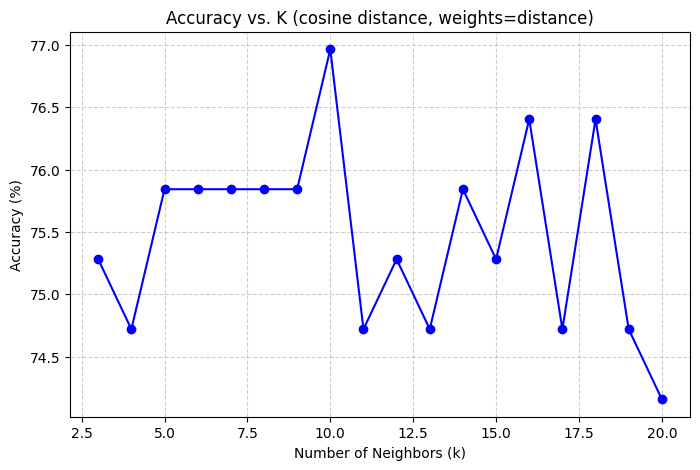

In [22]:
plot_different_k(3,20, distance="cosine", weights="distance")

In [17]:



predictions = Y_predicted.copy()
predictions = pd.DataFrame(predictions)

predictions.insert(0, "PassengerId", ids)
predictions.columns = ["PassengerId", "Survived"]
predictions.to_csv("submission.csv", index=False)